# Creating the CNN Model

In [2]:
import sys
assert sys.version_info >= (3, 5)

from PIL import Image
sys.modules['Image'] = Image 

import matplotlib.pyplot as plt
import numpy as np
import PIL
'''import tensorflow as tf'''

'''from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image'''

import os 

In [3]:
current_dir_path = os.getcwd() ## This extracts the current directory
data_folder = current_dir_path

In [4]:
current_dir_path 

'/Users/callum/Desktop/St_Andrews/2022-23/Sem 2/Biomedical Imaging and Sensing/Coursework 2'

In [5]:
# Specifies the directories for each folder: training, testing, and validating
train_dir = current_dir_path+'/chest_xray/train/'
test_dir = current_dir_path+'/chest_xray/test/'
val_dir = current_dir_path+'/chest_xray/val/'

In [6]:
train_dir ## Proof of concept that the directory worked

'/Users/callum/Desktop/St_Andrews/2022-23/Sem 2/Biomedical Imaging and Sensing/Coursework 2/chest_xray/train/'

In [7]:
import pathlib ## Creates a variable which represents the given paths

train_data = pathlib.Path(train_dir)
test_data = pathlib.Path(test_dir)
val_data = pathlib.Path(val_dir)

In [8]:
train_data

PosixPath('/Users/callum/Desktop/St_Andrews/2022-23/Sem 2/Biomedical Imaging and Sensing/Coursework 2/chest_xray/train')

In [8]:
## Counts the number of images in each folder for plotting

train_image_count = len(list(train_data.glob('*/*.jpeg'))) 
test_image_count = len(list(test_data.glob('*/*.jpeg')))
val_image_count = len(list(val_data.glob('*/*.jpeg')))
print(train_image_count, test_image_count, val_image_count)

5216 624 16


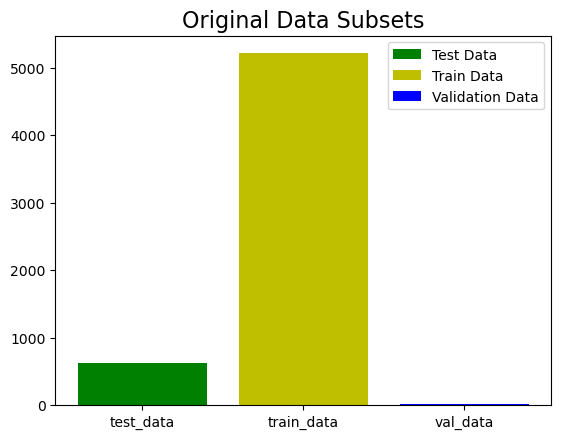

In [12]:
# Visualises the number of images per category

fig, axis = plt.subplots()
axis.bar("test_data", int(test_image_count), color='g', label='Test Data')
axis.bar("train_data",int(train_image_count), color='y', label='Train Data')
axis.bar("val_data",int(val_image_count) , color='b', label='Validation Data')
legend = axis.legend()
plt.title('Original Data Subsets', fontsize=16)
plt.savefig('data_subsets.png')
plt.show()

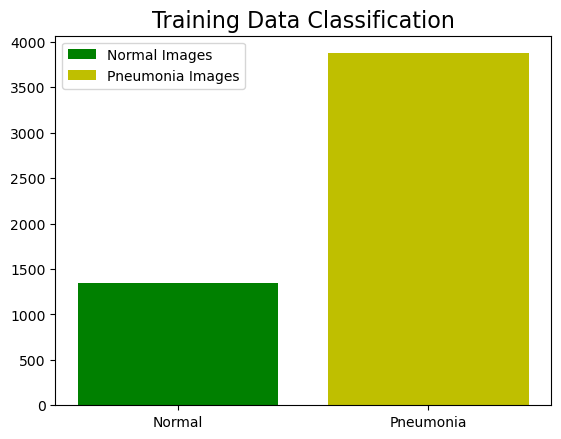

In [11]:
# Visualises the number of normal and pneumonia images in the training set

fig, axis = plt.subplots()
axis.bar("Normal", len(list(train_data.glob('NORMAL/*.jpeg'))), color='g', label='Normal Images')
axis.bar("Pneumonia",len(list(train_data.glob('PNEUMONIA/*.jpeg'))), color='y', label='Pneumonia Images')
legend = axis.legend()
plt.title('Training Data Classification', fontsize=16)
plt.savefig('image_stats.png')
plt.show()

In [12]:
## Extracts data from the training lists into two variables for easy plotting. Not necessary but makes it easier.

normal = list(train_data.glob('NORMAL/*'))
pneumonia = list(train_data.glob('PNEUMONIA/*'))

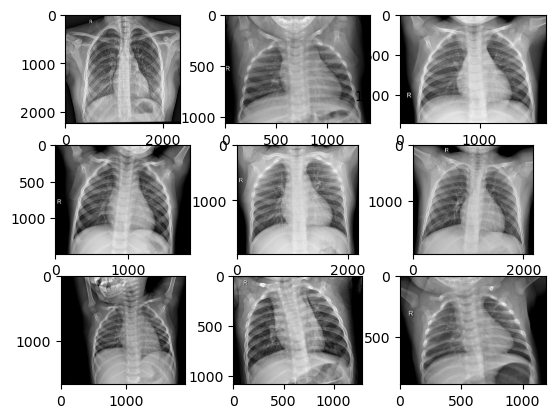

In [14]:
## Creates a 3*3 plot showing the first 9 images in the normal training set

for i in range(9): ## Loops through 0-9
    plt.subplot(3,3,i+1) ## Creates a 3*3 subplot
    plt.imshow(PIL.Image.open(str(normal[i])), plt.cm.gray) ## Plots the i image in each position
plt.savefig('normal_pics.png')
plt.show() ## Shows all 9 plots in one figure

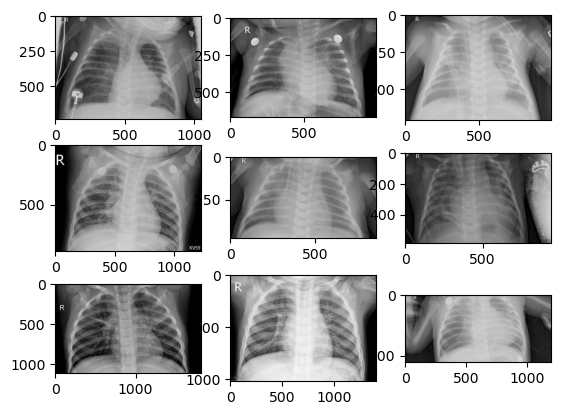

In [15]:
## Repeat from above, but using pneumonia images this time.

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(PIL.Image.open(str(pneumonia[i])), plt.cm.gray)
plt.savefig('pneumonia_pics.png')
plt.show()

In [13]:
## Defines starting parameters for the CNN model

batch_size = 32 ## Batch of 32 means 32 images are used in each set for training of the model weights
img_height = 244 ## Resizes all images to 244*244
img_width = 244

In [14]:
## I decided to manipulate the training data as the validation set is so small. Here I can extract 80% of the 
## training data for training, and the other 20% for validation, increasing the validation size. 
## The seed MUST be kept the same in order to not extract the same image in both datasets.

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir, ## Extracts data from the training directory
  validation_split=0.2, ## Splits 20% for validation
  subset="training", ## This is the trainin subset
  seed=123, ## Seed is 123 for reproducability and to not sample the same image in both training and validation
  image_size=(img_height, img_width), ## Images are re-sized to 244,244
  batch_size=batch_size) ## Batches of 32 are taken for training

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir, ## Test data taken from the test directory
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir, ## Validation is taken from the training directory
  validation_split=0.2, ## 20% 
  subset="validation", ## This is the validation subset
  seed=123, ## Uses the same seed so we do not re-sample the same images in both subsets
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 624 files belonging to 2 classes.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.


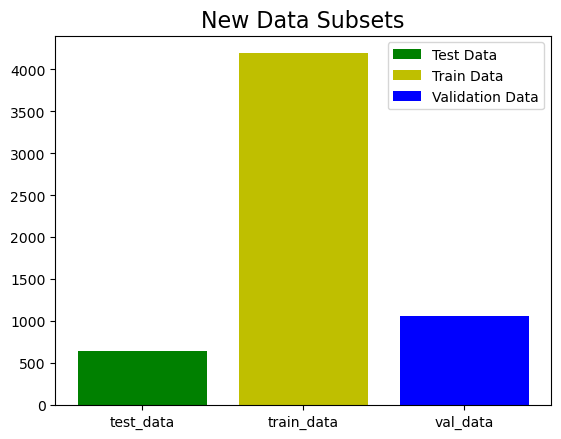

In [15]:
# We can now replot the bar chart to see the dataset sizes. The validation set has increased to 1043.

fig, axis = plt.subplots()
axis.bar("test_data", len(test_ds)*batch_size, color='g', label='Test Data')
axis.bar("train_data",len(train_ds)*batch_size, color='y', label='Train Data')
axis.bar("val_data",len(val_ds)*batch_size , color='b', label='Validation Data')
legend = axis.legend()
plt.title('New Data Subsets', fontsize=16)
plt.savefig('new_subsets.png')
plt.show()

In [19]:
## Extracts the lables from each dataset. We shouldn't look at the testing labels at all. 

train_labels = np.concatenate([y for x, y in train_ds], axis=0)
val_labels = np.concatenate([y for x, y in val_ds], axis=0)
test_labels = np.concatenate([y for x, y in test_ds], axis=0)

2023-04-03 21:12:58.079545: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [20]:
## Prints the data for the batches. We have batches of 32 in shape 244,244,3 (Three channel 244*244 images).
## We also have 32 labels for each batch (as we have 32 images)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 244, 244, 3)
(32,)


In [21]:
## This is used to optimise the model whilst it is running - optimising the CPU space

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
## Normalises all images so pixel values are between 0-1

normalization_layer = layers.Rescaling(1./255)

In [23]:
## Applies normalisation to the training datasets
## Prints the min and max pixel value for the first image in the first batch. We can see its between 0 and 1.

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 1.0


In [25]:
## Prints the class names from the data. We have both NORMAL and PNEUMONIA which is correct.

class_names = ['NORMAL', 'PNEUMONIA']
print(class_names)

['NORMAL', 'PNEUMONIA']


In [26]:
## Defines the first CNN model

num_classes = len(class_names) ## We have two classes

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), ## First layer rescales image size and pixel values
  layers.Conv2D(16, 3, padding='same', activation='relu'), ## First Convolutional layer. 
  layers.MaxPooling2D(), ## Pools the max value in each kernel to reduce dimensionality of the image
  layers.Conv2D(32, 3, padding='same', activation='relu'), ## Second convolutional layer
  layers.MaxPooling2D(), ## Pools the max value in each kernel to reduce dimensionality of the image
  layers.Conv2D(64, 3, padding='same', activation='relu'), ## Third convolutional layer
  layers.MaxPooling2D(), ## Pools the max value in each kernel to reduce dimensionality of the image
  layers.Flatten(), ## Flattens the image to pixel values. Compresses image to new dimension and pixel values.
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [27]:
## Compiles the model for use

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
## Provies a summary of the model, including number of parameters and layers

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 244, 244, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 244, 244, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 122, 122, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 64)        1

In [29]:
## I have commented this code out as it is not requried to run. The model is not very good, so I move on to a more
## fine-tuned model for the final model. 

'''epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)'''

'epochs=15\nhistory = model.fit(\n  train_ds,\n  validation_data=val_ds,\n  epochs=epochs\n)'

In [30]:
'''acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()'''

"acc = history.history['accuracy']\nval_acc = history.history['val_accuracy']\n\nloss = history.history['loss']\nval_loss = history.history['val_loss']\n\nepochs_range = range(epochs)\n\nplt.figure(figsize=(8, 8))\nplt.subplot(1, 2, 1)\nplt.plot(epochs_range, acc, label='Training Accuracy')\nplt.plot(epochs_range, val_acc, label='Validation Accuracy')\nplt.legend(loc='lower right')\nplt.title('Training and Validation Accuracy')\n\nplt.subplot(1, 2, 2)\nplt.plot(epochs_range, loss, label='Training Loss')\nplt.plot(epochs_range, val_loss, label='Validation Loss')\nplt.legend(loc='upper right')\nplt.title('Training and Validation Loss')\nplt.show()"

In [31]:
## Augments the data to add variation to the images, effectively increasing the number of training images by 
## flipping, scalling, and rotating the images. Adds variation in each batch.

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

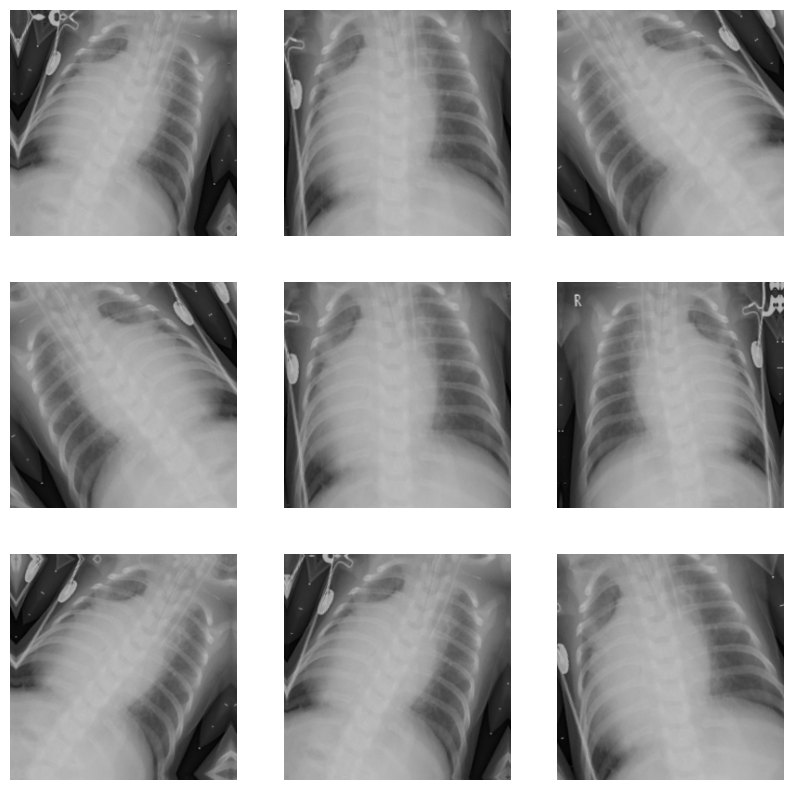

In [32]:
## Plots 9 of the randomly augmented images to visualise

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
    
plt.savefig('augmented_images.png')

In [33]:
## New model. Here we include the data augmentation step at the beginning for each batch
## Dropout has also been included here, where we randomly remove a subset at each step increasing regularisation.
## This is the model we will run

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),
  layers.Dense(num_classes, name="outputs")
])

In [34]:
## Compiles the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
## Sumamry of the model

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 244, 244, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 244, 244, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 244, 244, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 122, 122, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 122, 122, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                  

In [36]:
## Runs 20 epochs (20 runs) of the model. 

epochs = 20
history = model.fit( ## Fits the model using the training data set, calculating stats using the validation dataset
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
131/131 [==============================] - 45s 333ms/step - loss: 0.5274 - accuracy: 0.7620 - val_loss: 0.2289 - val_accuracy: 0.9099
Epoch 2/20
131/131 [==============================] - 42s 321ms/step - loss: 0.2723 - accuracy: 0.8821 - val_loss: 0.1254 - val_accuracy: 0.9501
Epoch 3/20
131/131 [==============================] - 42s 322ms/step - loss: 0.2218 - accuracy: 0.9121 - val_loss: 0.1490 - val_accuracy: 0.9444
Epoch 4/20
131/131 [==============================] - 42s 320ms/step - loss: 0.2145 - accuracy: 0.9130 - val_loss: 0.1302 - val_accuracy: 0.9473
Epoch 5/20
131/131 [==============================] - 42s 319ms/step - loss: 0.1670 - accuracy: 0.9329 - val_loss: 0.1109 - val_accuracy: 0.9578
Epoch 6/20
131/131 [==============================] - 42s 321ms/step - loss: 0.1661 - accuracy: 0.9370 - val_loss: 0.0908 - val_accuracy: 0.9626
Epoch 7/20
131/131 [==============================] - 42s 322ms/step - loss: 0.1542 - accuracy: 0.9399 - val_loss: 0.0919 - val_ac

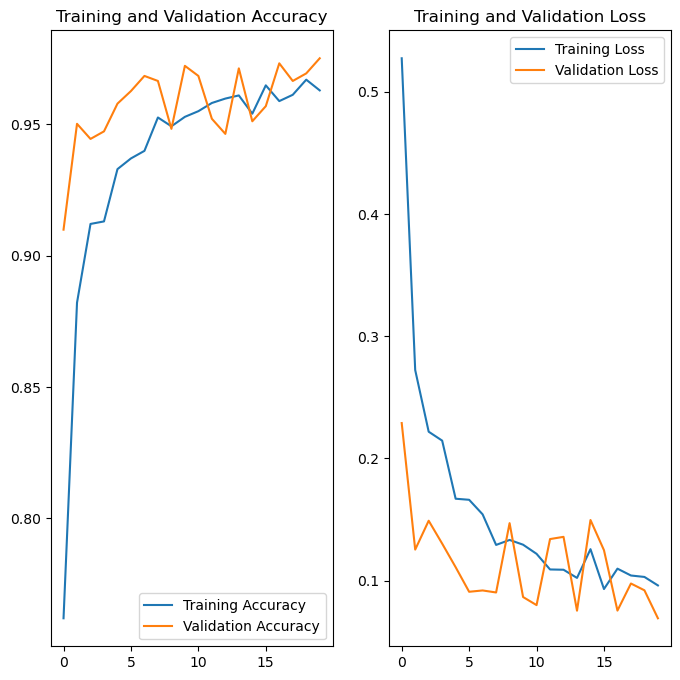

In [37]:
## Extracts stats from the model and plots these statistics over the n epochs. 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('model_statistics.png')
plt.show()


In [39]:
%%time
## Predicts on our testing set using the final model

y_predict = model.predict(test_ds)
y_predict = np.argmax(y_predict,axis=1)

20/20 [==============================] - 2s 77ms/step
CPU times: user 11.1 s, sys: 1.04 s, total: 12.2 s
Wall time: 1.89 s


1/1 [==============================] - 0s 48ms/step


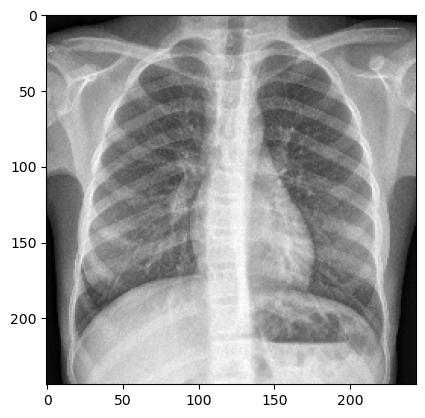

This image most likely belongs to NORMAL with a 76.00 percent confidence.


In [40]:
## Loads an image, predicts the classification, and outputs the classification with the confidence score.

img = image.load_img(test_dir+"NORMAL/IM-0033-0001-0002.jpeg", target_size=(244, 244)) ## Loads the image
img_array = tf.keras.utils.img_to_array(img) ## Converts image to pixel values
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array) ## Runs the model on the pixel values for this image
score = tf.nn.softmax(predictions[0]) ## Gives a predictive score

plt.imshow(img) ## Plots the image
plt.show()

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
) ## Prints the classification and the confidence

1/1 [==============================] - 0s 22ms/step


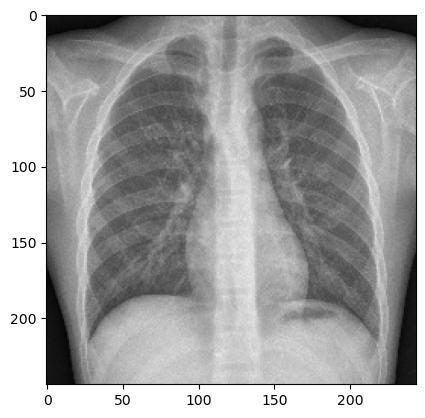

This image most likely belongs to NORMAL with a 77.39 percent confidence.


In [41]:
img = image.load_img(test_dir+"NORMAL/IM-0017-0001.jpeg", target_size=(244, 244))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

plt.imshow(img)
plt.show()

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 19ms/step


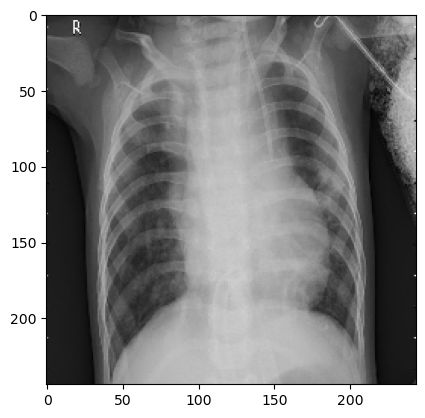

This image most likely belongs to PNEUMONIA with a 99.99 percent confidence.


In [42]:
img = image.load_img(test_dir+"PNEUMONIA/person103_bacteria_489.jpeg", target_size=(244, 244))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

plt.imshow(img)
plt.show()

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [43]:
## Runs the model on the training dataset

train_predict = model.predict(train_ds)
train_predict = np.argmax(train_predict,axis=1)

131/131 [==============================] - 9s 70ms/step


In [44]:
## Runs the model on the validation dataset

val_predict = model.predict(val_ds)
val_predict = np.argmax(val_predict, axis=1)

33/33 [==============================] - 2s 70ms/step


In [45]:
## Codes the confusion matrices for each dataset

train_cf_matrix = tf.math.confusion_matrix(
    train_labels,
    train_predict,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

test_cf_matrix = tf.math.confusion_matrix(
    test_labels,
    y_predict,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

val_cf_matrix = tf.math.confusion_matrix(
    val_labels,
    val_predict,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

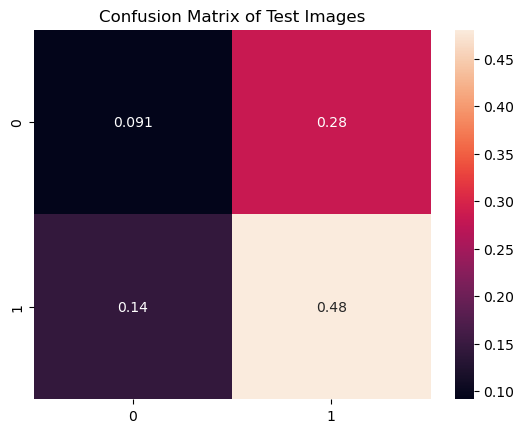

In [48]:
## Plots the testing confusion matrix

import seaborn as sns
test_cm = sns.heatmap(test_cf_matrix/np.sum(test_cf_matrix), annot=True).set(title='Confusion Matrix of Test Images')
plt.savefig("test_cm.png") 

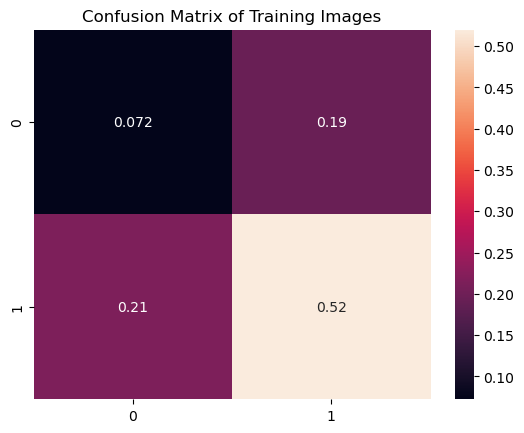

In [49]:
## Plots the training confusion matrix

train_cm = sns.heatmap(train_cf_matrix/np.sum(train_cf_matrix), annot=True).set(title='Confusion Matrix of Training Images')
plt.savefig("train_cm.png") 

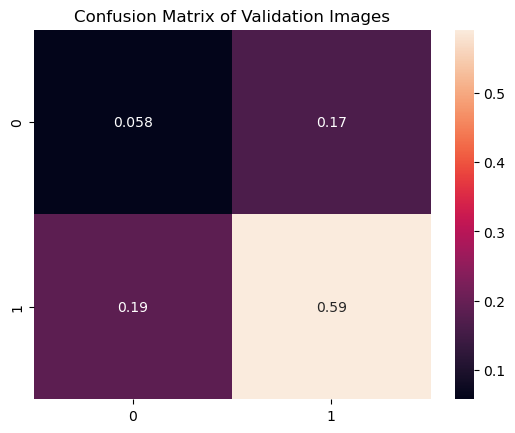

In [50]:
## Plots the validation confusion matrix

val_cm = sns.heatmap(val_cf_matrix/np.sum(val_cf_matrix), annot=True).set(title='Confusion Matrix of Validation Images')
plt.savefig("val_cm.png") 

In [ ]:
## Saves the model

model.save("pneumonia_model.h5")

# Creating the Video

In [ ]:
## Imports CV2 for creating the video

import cv2
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
## Specifies the directories for the testing NORMAL and testing PNEUMONIA

normal_dir = current_dir_path+'/chest_xray/test/NORMAL/'
pneumonia_dir = current_dir_path+'/chest_xray/test/PNEUMONIA/'

In [ ]:
## Defines the font parameters for the font overlayed on each image

font = cv2.FONT_HERSHEY_SIMPLEX
fontscale = 0.5
color = (255,255,255)
font_thickness = 1
org = (10,230)

## Defines the movie making function. adapted from https://stackoverflow.com/questions/72923711/the-document-could-not-be-opened-opencv-python3

def convert_pictures_to_video(pathIn, pathOut, fps, time): ## Takes input of the input path, output, fps and length of each slide
    ''' this function converts images to video'''
    frame_array=[] ## Creates an empty array to append each image to
    files=[f for f in os.listdir(pathIn)] 
    for i in range (len(files)): ## Loops through each image in the input directory
        filename=pathIn+files[i] ## Creates full filepath with input directory and filename
        img = image.load_img(filename, target_size=(244, 244)) ## Loads the file so we can run the model 
        img_array = tf.keras.utils.img_to_array(img) ## Converts image to pixel array
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array) ## Runs the model on the pixel array
        score = tf.nn.softmax(predictions[0]) ## Calculates the prediction so we can label the image
        '''reading images'''
        img=cv2.imread(filename) ## Reads the file again, using CV2 for plotting
        img=cv2.resize(img,(244,244)) ## Resizes images to 244,244
        img = cv2.putText(img,'Prediction:'+str(class_names[np.argmax(score)]), org, font, fontscale, color, font_thickness, cv2.LINE_AA)
        size=(244,244) ## Plots image, and adds text which updates based on the prediction of each image

        for k in range (time): ## Creates a loop based on the time of each slide (in seconds)
            frame_array.append(img) ## Appends the image n numbers of times (for n seconds)
    out=cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'mp4v'), fps,size) ## Writes the frame out to variable 'out' 
    for i in range(len(frame_array)): ## Loops through every frame
        out.write(frame_array[i]) ## Writes each frame to 'out'
    out.release() ## Releases the video after all files have been looped through

In [ ]:
pathIn=pneumonia_dir ## Defines the chosen directory - here we choose the test/PNEUMONIA directory
pathOut=current_dir_path+'/pneumonia_images.mp4' ## Defines the output file directory and name
fps=1 ## Defines FPS as 1
time=1 # Defines the duration of each picture in the video
convert_pictures_to_video(pathIn, pathOut, fps, time) ## Runs the function to create the video

In [ ]:
pathIn=normal_dir
pathOut=current_dir_path+'/normal_images.mp4'
fps=1
time=1 # the duration of each picture in the video
convert_pictures_to_video(pathIn, pathOut, fps, time)